# DuckDB Metrics Analysis

This notebook connects to the DuckDB client container and queries the metrics stored in MinIO.

## Setup

First, we need to install the DuckDB Python package and set up a connection.

In [1]:
# Install DuckDB and pandas
!pip install duckdb pandas matplotlib seaborn numpy


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Connect to DuckDB

Now, let's connect to DuckDB and configure it to access MinIO.

In [7]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up a prettier plot style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Connect to DuckDB
conn = duckdb.connect(database=':memory:')

# Install required extensions
conn.execute("INSTALL httpfs; LOAD httpfs;")
conn.execute("INSTALL json; LOAD json;")

pd.options.display.max_columns = None


## Configure MinIO Connection

Now, let's configure DuckDB to connect to MinIO. Update these parameters to match your environment settings.

In [8]:
# MinIO configuration - update these values as needed
MINIO_ENDPOINT = "localhost:9090"  # Use localhost since we're connecting from outside the container
MINIO_ACCESS_KEY = "minioadmin"
MINIO_SECRET_KEY = "minioadmin"
MINIO_BUCKET = "warehouse"

# Configure S3 connection in DuckDB
conn.execute(f"SET s3_endpoint='{MINIO_ENDPOINT}';")
conn.execute(f"SET s3_access_key_id='{MINIO_ACCESS_KEY}';")
conn.execute(f"SET s3_secret_access_key='{MINIO_SECRET_KEY}';")
conn.execute("SET s3_url_style='path';")
conn.execute("SET s3_use_ssl=false;")
conn.execute("CREATE SCHEMA IF NOT EXISTS minio_stats;")

sqlsetup = f"""
CREATE OR REPLACE VIEW minio_stats.pipeline_metrics AS
SELECT
  config,
  runtime.timestamp,
  runtime.duration_ms AS runtime_ms,
  
  -- Producer metrics
  producer.duration_ms AS producer_duration_ms,
  producer.events AS producer_events,
  producer.events_per_second AS producer_events_per_second,
  
  -- Consumer metrics
  consumer.duration_ms AS consumer_duration_ms,
  consumer.events AS consumer_events,
  consumer.events_per_second AS consumer_events_per_second,
  
  -- MinIO Raw metrics
  minio_raw.duration_ms AS minio_raw_duration_ms,
  minio_raw.puts AS minio_raw_puts,
  minio_raw.puts_per_second AS minio_raw_puts_per_second,
  minio_raw.bytes_per_second AS minio_raw_bytes_per_second,
  minio_raw.bytes AS minio_raw_bytes,
  minio_raw.size.max_bytes AS minio_raw_size_max_bytes,
  minio_raw.size.mean_bytes AS minio_raw_size_mean_bytes,
  minio_raw.size.percentiles.p25 AS minio_raw_size_percentiles_p25,
  minio_raw.size.percentiles.p50 AS minio_raw_size_percentiles_p50,
  minio_raw.size.percentiles.p75 AS minio_raw_size_percentiles_p75,
  minio_raw.size.percentiles.p90 AS minio_raw_size_percentiles_p90,
  minio_raw.size.percentiles.p95 AS minio_raw_size_percentiles_p95,
  minio_raw.latency.mean_ms AS minio_raw_latency_mean_ms,
  minio_raw.latency.max_ms AS minio_raw_latency_max_ms,
  minio_raw.latency.percentiles.p25 AS minio_raw_latency_percentiles_p25,
  minio_raw.latency.percentiles.p50 AS minio_raw_latency_percentiles_p50,
  minio_raw.latency.percentiles.p75 AS minio_raw_latency_percentiles_p75,
  minio_raw.latency.percentiles.p90 AS minio_raw_latency_percentiles_p90,
  minio_raw.latency.percentiles.p95 AS minio_raw_latency_percentiles_p95,
  
  -- MinIO Agg metrics
  minio_agg.duration_ms AS minio_agg_duration_ms,
  minio_agg.puts AS minio_agg_puts,
  minio_agg.puts_per_second AS minio_agg_puts_per_second,
  minio_agg.bytes_per_second AS minio_agg_bytes_per_second,
  minio_agg.bytes AS minio_agg_bytes,
  minio_agg.size.mean_bytes AS minio_agg_size_mean_bytes,
  minio_agg.size.percentiles.p25 AS minio_agg_size_percentiles_p25,
  minio_agg.size.percentiles.p50 AS minio_agg_size_percentiles_p50,
  minio_agg.size.percentiles.p75 AS minio_agg_size_percentiles_p75,
  minio_agg.size.percentiles.p90 AS minio_agg_size_percentiles_p90,
  minio_agg.size.percentiles.p95 AS minio_agg_size_percentiles_p95,
  minio_agg.latency.mean_ms AS minio_agg_latency_mean_ms,
  minio_agg.latency.max_ms AS minio_agg_latency_max_ms,
  minio_agg.latency.percentiles.p25 AS minio_agg_latency_percentiles_p25,
  minio_agg.latency.percentiles.p50 AS minio_agg_latency_percentiles_p50,
  minio_agg.latency.percentiles.p75 AS minio_agg_latency_percentiles_p75,
  minio_agg.latency.percentiles.p90 AS minio_agg_latency_percentiles_p90,
  minio_agg.latency.percentiles.p95 AS minio_agg_latency_percentiles_p95

FROM read_json_auto('s3://{MINIO_BUCKET}/stats/pipeline_metrics_*.json');
"""

conn.execute(sqlsetup)

"""
-- Help message
.print '======================================================================================'
.print 'DuckDB client connected to MinIO at ${MINIO_ENDPOINT}'
.print 'Usage examples:'
.print '  - View all metrics: SELECT * FROM minio_stats.pipeline_metrics;'
.print '  - Query specific metrics: SELECT timestamp, producer_events_per_second, consumer_events_per_second FROM minio_stats.pipeline_metrics;'
.print '======================================================================================' 
"""

"\n-- Help message\n.print '======================================================================================'\n.print 'DuckDB client connected to MinIO at ${MINIO_ENDPOINT}'\n.print 'Usage examples:'\n.print '  - View all metrics: SELECT * FROM minio_stats.pipeline_metrics;'\n.print '  - Query specific metrics: SELECT timestamp, producer_events_per_second, consumer_events_per_second FROM minio_stats.pipeline_metrics;'\n.print '======================================================================================' \n"

## Query Metrics Data

Now, let's create a view to query the metrics data stored in JSON format.

In [9]:
# Define SQL query to extract metrics from JSON files
query = f"""
SELECT * FROM minio_stats.pipeline_metrics 
"""

# Execute the query
try:
    metrics_df = conn.execute(query).fetchdf()
    print(f"Retrieved {len(metrics_df)} metrics records")
    pct_cols = [c for c in metrics_df.columns if 'percentiles' in c]
    metrics_df[pct_cols] = metrics_df[pct_cols].apply(pd.to_numeric, errors='coerce')
    producer_metrics_df = metrics_df[metrics_df['producer_events'].notna()]
    consumer_metrics_df = metrics_df[metrics_df['consumer_events'].notna()]
    display(metrics_df)
    display(producer_metrics_df)
    display(consumer_metrics_df)
except Exception as e:
    print(f"Error retrieving metrics: {e}")
    print("If no files were found, try running the application first to generate metrics data.")

Retrieved 2 metrics records


,config,timestamp,runtime_ms,producer_duration_ms,producer_events,producer_events_per_second,consumer_duration_ms,consumer_events,consumer_events_per_second,minio_raw_duration_ms,minio_raw_puts,minio_raw_puts_per_second,minio_raw_bytes_per_second,minio_raw_bytes,minio_raw_size_max_bytes,minio_raw_size_mean_bytes,minio_raw_size_percentiles_p25,minio_raw_size_percentiles_p50,minio_raw_size_percentiles_p75,minio_raw_size_percentiles_p90,minio_raw_size_percentiles_p95,minio_raw_latency_mean_ms,minio_raw_latency_max_ms,minio_raw_latency_percentiles_p25,minio_raw_latency_percentiles_p50,minio_raw_latency_percentiles_p75,minio_raw_latency_percentiles_p90,minio_raw_latency_percentiles_p95,minio_agg_duration_ms,minio_agg_puts,minio_agg_puts_per_second,minio_agg_bytes_per_second,minio_agg_bytes,minio_agg_size_mean_bytes,minio_agg_size_percentiles_p25,minio_agg_size_percentiles_p50,minio_agg_size_percentiles_p75,minio_agg_size_percentiles_p90,minio_agg_size_percentiles_p95,minio_agg_latency_mean_ms,minio_agg_latency_max_ms,minio_agg_latency_percentiles_p25,minio_agg_latency_percentiles_p50,minio_agg_latency_percentiles_p75,minio_agg_latency_percentiles_p90,minio_agg_latency_percentiles_p95
0,10000000::10000::1000::226,2025-05-13T05:53:23.239932334Z,297265,297262,10000000.0,33640.357664,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000000::10000::1000::226,2025-05-13T05:53:22.314037110Z,398312,<NA>,NaN,NaN,398204,10000000.0,25112.756276,398204,3227.0,8.103886,7.261230e+06,2.891451e+09,901036.0,896018.264022,913408.0,913408.0,913408.0,913408.0,913408.0,41.851812,275.369746,21.495808,22.544384,23.59296,29.884416,31.981568,398205,3224.0,8.096332,2.581482e+06,1.027959e+09,318845.816687,319488.0,319488.0,319488.0,319488.0,319488.0,23.192341,195.557932,13.1072,13.631488,14.155776,15.72864,19.398656


,config,timestamp,runtime_ms,producer_duration_ms,producer_events,producer_events_per_second,consumer_duration_ms,consumer_events,consumer_events_per_second,minio_raw_duration_ms,minio_raw_puts,minio_raw_puts_per_second,minio_raw_bytes_per_second,minio_raw_bytes,minio_raw_size_max_bytes,minio_raw_size_mean_bytes,minio_raw_size_percentiles_p25,minio_raw_size_percentiles_p50,minio_raw_size_percentiles_p75,minio_raw_size_percentiles_p90,minio_raw_size_percentiles_p95,minio_raw_latency_mean_ms,minio_raw_latency_max_ms,minio_raw_latency_percentiles_p25,minio_raw_latency_percentiles_p50,minio_raw_latency_percentiles_p75,minio_raw_latency_percentiles_p90,minio_raw_latency_percentiles_p95,minio_agg_duration_ms,minio_agg_puts,minio_agg_puts_per_second,minio_agg_bytes_per_second,minio_agg_bytes,minio_agg_size_mean_bytes,minio_agg_size_percentiles_p25,minio_agg_size_percentiles_p50,minio_agg_size_percentiles_p75,minio_agg_size_percentiles_p90,minio_agg_size_percentiles_p95,minio_agg_latency_mean_ms,minio_agg_latency_max_ms,minio_agg_latency_percentiles_p25,minio_agg_latency_percentiles_p50,minio_agg_latency_percentiles_p75,minio_agg_latency_percentiles_p90,minio_agg_latency_percentiles_p95
0,10000000::10000::1000::226,2025-05-13T05:53:23.239932334Z,297265,297262,10000000.0,33640.357664,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,config,timestamp,runtime_ms,producer_duration_ms,producer_events,producer_events_per_second,consumer_duration_ms,consumer_events,consumer_events_per_second,minio_raw_duration_ms,minio_raw_puts,minio_raw_puts_per_second,minio_raw_bytes_per_second,minio_raw_bytes,minio_raw_size_max_bytes,minio_raw_size_mean_bytes,minio_raw_size_percentiles_p25,minio_raw_size_percentiles_p50,minio_raw_size_percentiles_p75,minio_raw_size_percentiles_p90,minio_raw_size_percentiles_p95,minio_raw_latency_mean_ms,minio_raw_latency_max_ms,minio_raw_latency_percentiles_p25,minio_raw_latency_percentiles_p50,minio_raw_latency_percentiles_p75,minio_raw_latency_percentiles_p90,minio_raw_latency_percentiles_p95,minio_agg_duration_ms,minio_agg_puts,minio_agg_puts_per_second,minio_agg_bytes_per_second,minio_agg_bytes,minio_agg_size_mean_bytes,minio_agg_size_percentiles_p25,minio_agg_size_percentiles_p50,minio_agg_size_percentiles_p75,minio_agg_size_percentiles_p90,minio_agg_size_percentiles_p95,minio_agg_latency_mean_ms,minio_agg_latency_max_ms,minio_agg_latency_percentiles_p25,minio_agg_latency_percentiles_p50,minio_agg_latency_percentiles_p75,minio_agg_latency_percentiles_p90,minio_agg_latency_percentiles_p95
1,10000000::10000::1000::226,2025-05-13T05:53:22.314037110Z,398312,<NA>,NaN,NaN,398204,10000000.0,25112.756276,398204,3227.0,8.103886,7.261230e+06,2.891451e+09,901036.0,896018.264022,913408.0,913408.0,913408.0,913408.0,913408.0,41.851812,275.369746,21.495808,22.544384,23.59296,29.884416,31.981568,398205,3224.0,8.096332,2.581482e+06,1.027959e+09,318845.816687,319488.0,319488.0,319488.0,319488.0,319488.0,23.192341,195.557932,13.1072,13.631488,14.155776,15.72864,19.398656


## Visualize Performance Metrics

Let's create some visualizations to analyze the performance metrics.

/var/folders/nb/npb8qtg10n5102rglll5ts5r0000gn/T/ipykernel_89890/1960765192.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumer_metrics_df['timestamp'] = pd.to_datetime(consumer_metrics_df['timestamp'])


,config,timestamp,runtime_ms,producer_duration_ms,producer_events,producer_events_per_second,consumer_duration_ms,consumer_events,consumer_events_per_second,minio_raw_duration_ms,minio_raw_puts,minio_raw_puts_per_second,minio_raw_bytes_per_second,minio_raw_bytes,minio_raw_size_max_bytes,minio_raw_size_mean_bytes,minio_raw_size_percentiles_p25,minio_raw_size_percentiles_p50,minio_raw_size_percentiles_p75,minio_raw_size_percentiles_p90,minio_raw_size_percentiles_p95,minio_raw_latency_mean_ms,minio_raw_latency_max_ms,minio_raw_latency_percentiles_p25,minio_raw_latency_percentiles_p50,minio_raw_latency_percentiles_p75,minio_raw_latency_percentiles_p90,minio_raw_latency_percentiles_p95,minio_agg_duration_ms,minio_agg_puts,minio_agg_puts_per_second,minio_agg_bytes_per_second,minio_agg_bytes,minio_agg_size_mean_bytes,minio_agg_size_percentiles_p25,minio_agg_size_percentiles_p50,minio_agg_size_percentiles_p75,minio_agg_size_percentiles_p90,minio_agg_size_percentiles_p95,minio_agg_latency_mean_ms,minio_agg_latency_max_ms,minio_agg_latency_percentiles_p25,minio_agg_latency_percentiles_p50,minio_agg_latency_percentiles_p75,minio_agg_latency_percentiles_p90,minio_agg_latency_percentiles_p95
1,10000000::10000::1000::226,2025-05-13 05:53:22.314037110+00:00,398312,<NA>,NaN,NaN,398204,10000000.0,25112.756276,398204,3227.0,8.103886,7.261230e+06,2.891451e+09,901036.0,896018.264022,913408.0,913408.0,913408.0,913408.0,913408.0,41.851812,275.369746,21.495808,22.544384,23.59296,29.884416,31.981568,398205,3224.0,8.096332,2.581482e+06,1.027959e+09,318845.816687,319488.0,319488.0,319488.0,319488.0,319488.0,23.192341,195.557932,13.1072,13.631488,14.155776,15.72864,19.398656


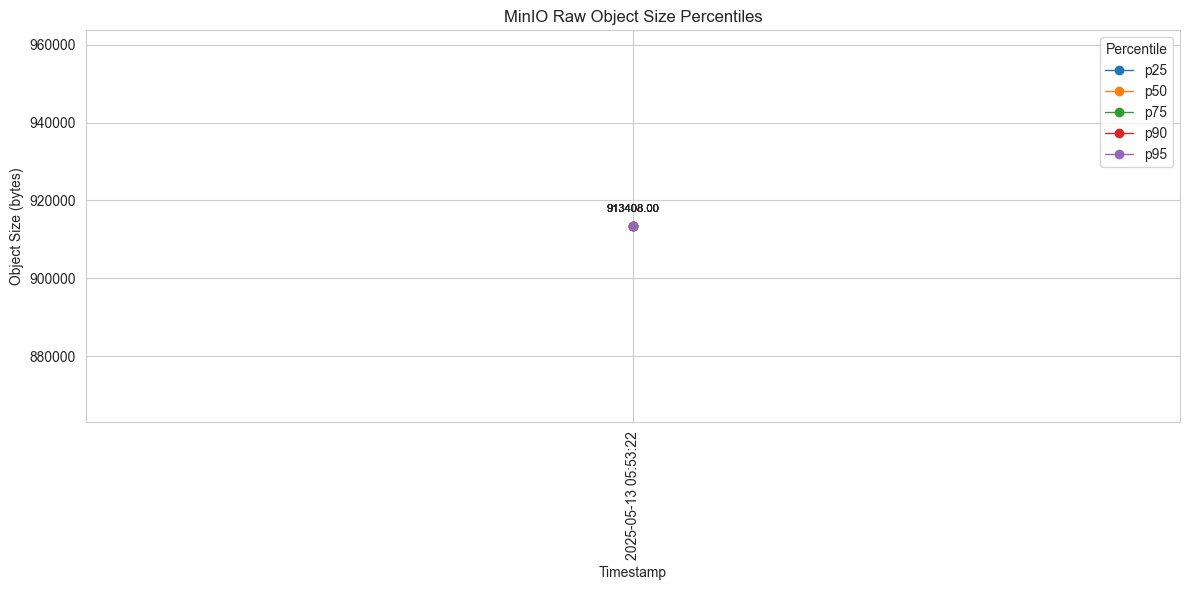

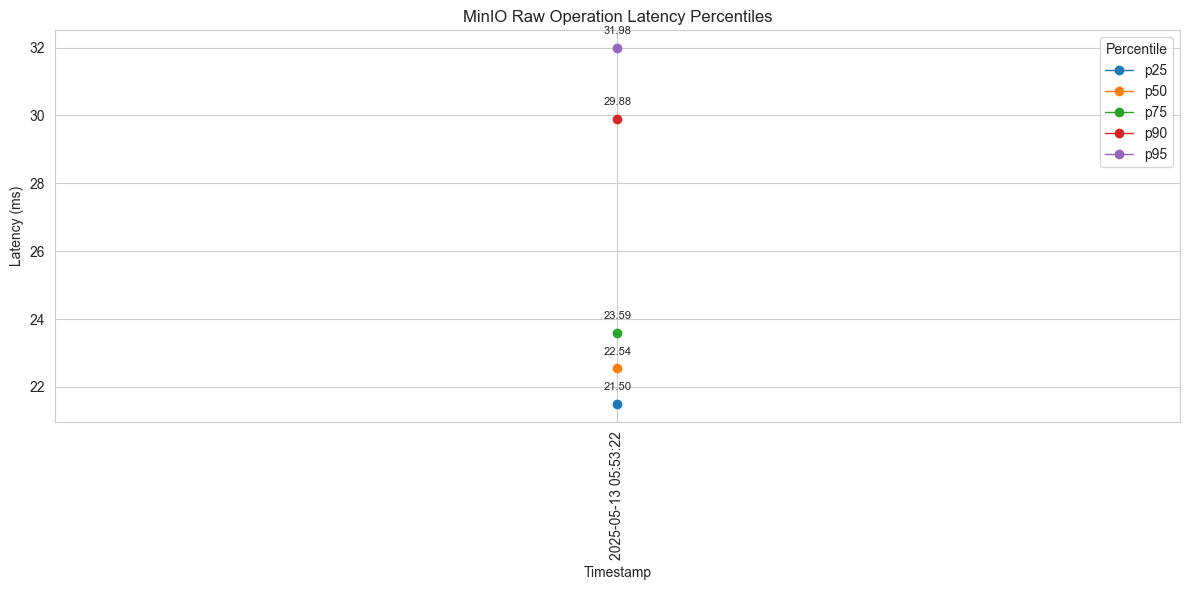

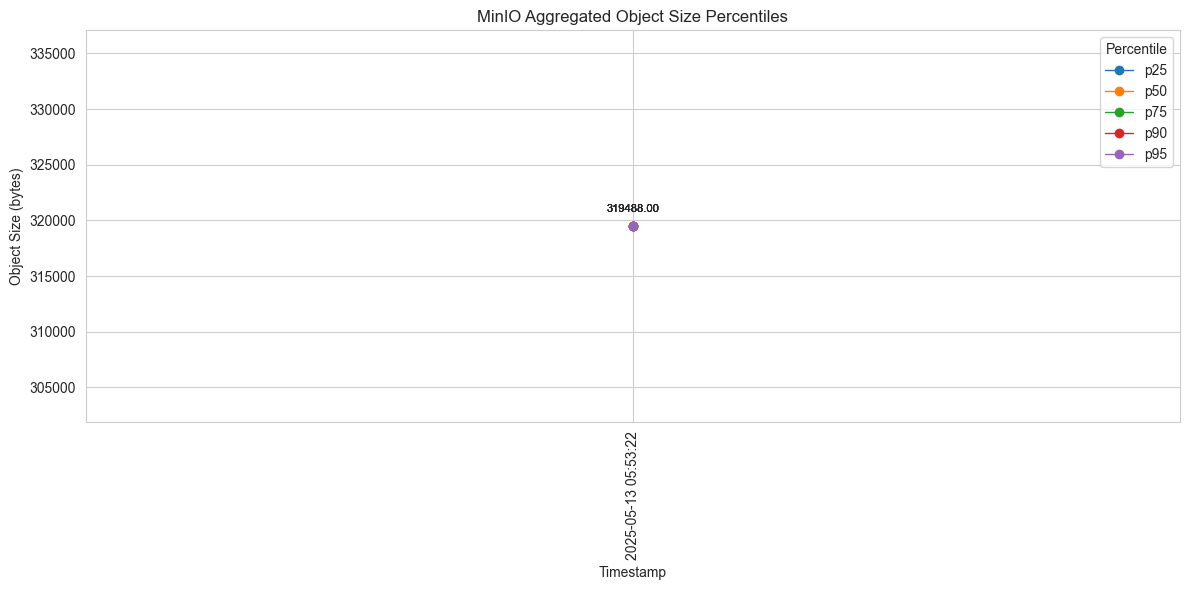

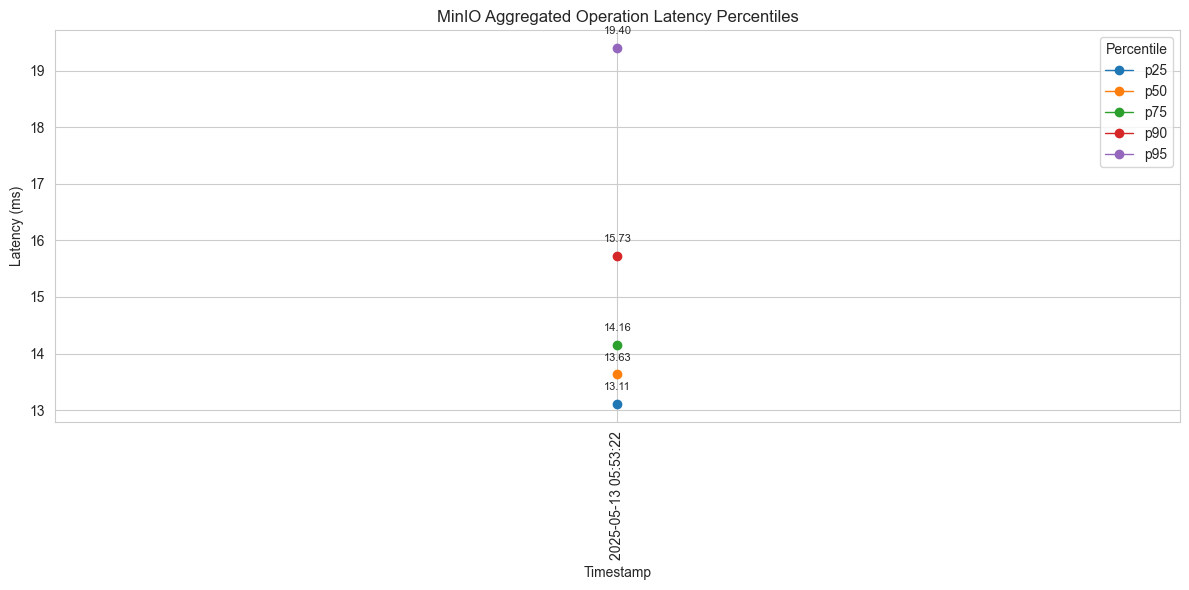

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ─── Prepare the DataFrame ────────────────────────────────────────────────────
consumer_metrics_df['timestamp'] = pd.to_datetime(consumer_metrics_df['timestamp'])
consumer_metrics_df = consumer_metrics_df.sort_values('timestamp')
display(consumer_metrics_df)

# ─── Percentiles to plot ──────────────────────────────────────────────────────
percentiles = ['25', '50', '75', '90', '95']

# ─── Configure datetime formatter for x-axis ─────────────────────────────────
date_format = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')

# ─── Chart: MinIO Raw Object Size Percentiles ───────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))
for p in percentiles:
    x_data = consumer_metrics_df['timestamp']
    y_data = consumer_metrics_df[f'minio_raw_size_percentiles_p{p}']    
    ax.plot(
        x_data,
        y_data,
        label=f'p{p}',
        linewidth=1,
        marker='o',
        markersize=6
    )
    for i, (x, y) in enumerate(zip(x_data, y_data)):
        ax.annotate(f"{y:.2f}", (x, y), xytext=(0, 10), 
                textcoords="offset points", ha='center', fontsize=8)    
        
ax.set_xlabel('Timestamp')
ax.set_ylabel('Object Size (bytes)')
ax.set_title('MinIO Raw Object Size Percentiles')
ax.legend(title='Percentile')
# Set exact timestamps as ticks
ax.set_xticks(consumer_metrics_df['timestamp'])
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=90)
plt.tight_layout()

# ─── Chart: MinIO Raw Operation Latency Percentiles ─────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))
for p in percentiles:   
    x_data = consumer_metrics_df['timestamp']
    y_data = consumer_metrics_df[f'minio_raw_latency_percentiles_p{p}']    
    ax.plot(
        x_data,
        y_data,
        label=f'p{p}',
        linewidth=1,
        marker='o',
        markersize=6
    )
    for i, (x, y) in enumerate(zip(x_data, y_data)):
        ax.annotate(f"{y:.2f}", (x, y), xytext=(0, 10), 
                textcoords="offset points", ha='center', fontsize=8)         

ax.set_xlabel('Timestamp')
ax.set_ylabel('Latency (ms)')
ax.set_title('MinIO Raw Operation Latency Percentiles')
ax.legend(title='Percentile')
# Set exact timestamps as ticks
ax.set_xticks(consumer_metrics_df['timestamp'])
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=90)
plt.tight_layout()

# ─── Chart: MinIO Aggregated Object Size Percentiles ────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))
for p in percentiles:
    x_data = consumer_metrics_df['timestamp']
    y_data = consumer_metrics_df[f'minio_agg_size_percentiles_p{p}']    
    ax.plot(
        x_data,
        y_data,
        label=f'p{p}',
        linewidth=1,
        marker='o',
        markersize=6
    )
    for i, (x, y) in enumerate(zip(x_data, y_data)):
        ax.annotate(f"{y:.2f}", (x, y), xytext=(0, 10), 
                textcoords="offset points", ha='center', fontsize=8)       

ax.set_xlabel('Timestamp')
ax.set_ylabel('Object Size (bytes)')
ax.set_title('MinIO Aggregated Object Size Percentiles')
ax.legend(title='Percentile')
# Set exact timestamps as ticks
ax.set_xticks(consumer_metrics_df['timestamp'])
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=90)
plt.tight_layout()

# ─── Chart: MinIO Aggregated Operation Latency Percentiles ───────────────────
fig, ax = plt.subplots(figsize=(12, 6))
for p in percentiles:
    x_data = consumer_metrics_df['timestamp']
    y_data = consumer_metrics_df[f'minio_agg_latency_percentiles_p{p}']    
    ax.plot(
        x_data,
        y_data,
        label=f'p{p}',
        linewidth=1,
        marker='o',
        markersize=6
    )
    for i, (x, y) in enumerate(zip(x_data, y_data)):
        ax.annotate(f"{y:.2f}", (x, y), xytext=(0, 10), 
                textcoords="offset points", ha='center', fontsize=8)       

ax.set_xlabel('Timestamp')
ax.set_ylabel('Latency (ms)')
ax.set_title('MinIO Aggregated Operation Latency Percentiles')
ax.legend(title='Percentile')
# Set exact timestamps as ticks
ax.set_xticks(consumer_metrics_df['timestamp'])
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

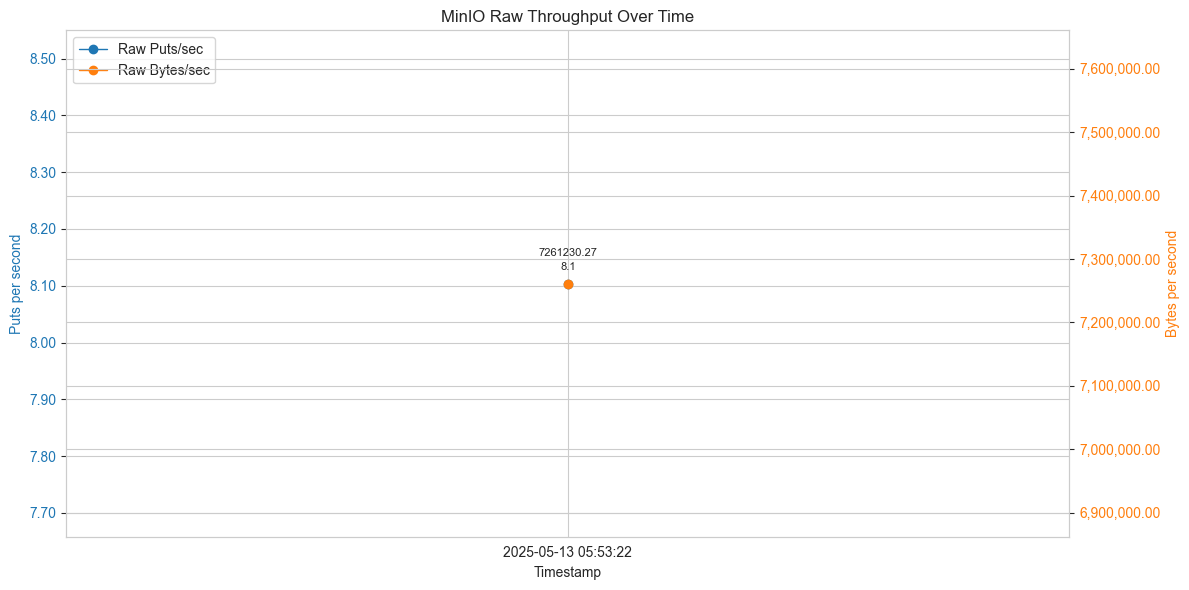

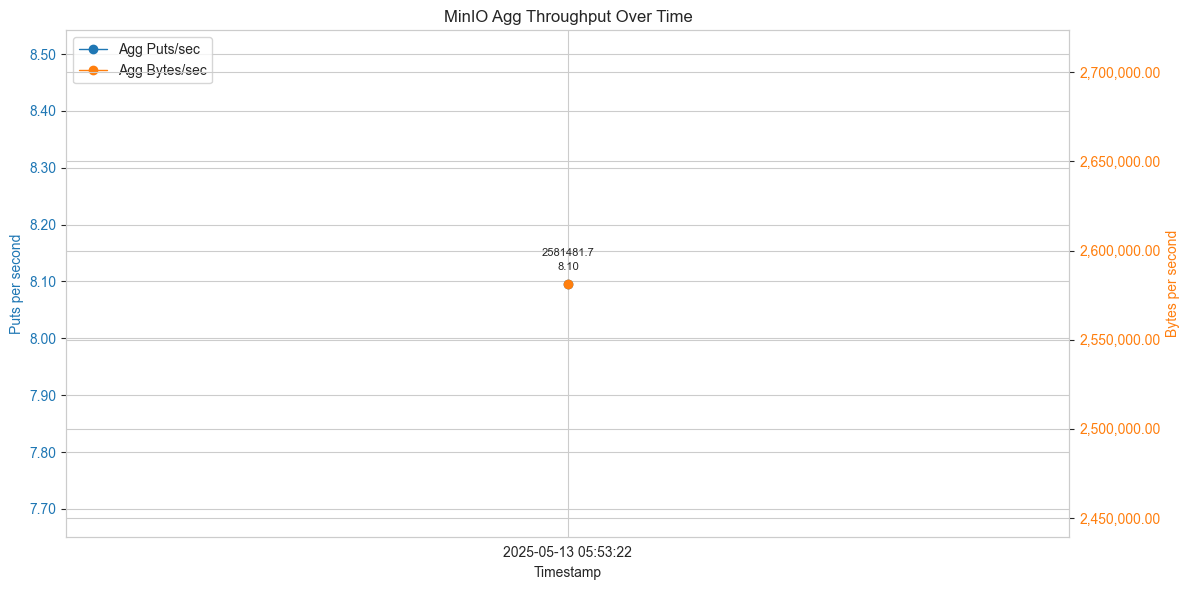

In [11]:

import pandas as pd
import matplotlib.pyplot as plt

# ─── Chart 1: MinIO Raw Throughput (Puts/sec & Bytes/sec) ─────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Plot puts/sec with formatted y-axis labels
x_date = consumer_metrics_df['timestamp']
y_data = consumer_metrics_df['minio_raw_puts_per_second']

puts_line = ax.plot(
    x_date,
    y_data,
    label='Raw Puts/sec',
    linewidth=1,
    marker='o',
    markersize=6,
    color='tab:blue'
)

for i, (x, y) in enumerate(zip(x_data, y_data)):
    ax.annotate(f"{y:.1f}", (x, y), xytext=(0, 10), 
            textcoords="offset points", ha='center', fontsize=8)
    
# Create a second y-axis for bytes/sec
ax2 = ax.twinx()
x_date = consumer_metrics_df['timestamp']
y_data = consumer_metrics_df['minio_raw_bytes_per_second']
bytes_line = ax2.plot(
    x_date,
    y_data,
    label='Raw Bytes/sec',
    linewidth=1,
    marker='o',
    markersize=6,
    color='tab:orange'
)

for i, (x, y) in enumerate(zip(x_data, y_data)):
    ax2.annotate(f"{y:.2f}", (x, y), xytext=(0, 20), 
            textcoords="offset points", ha='center', fontsize=8)

from matplotlib.ticker import FuncFormatter
def format_as_float(x, _):
    return f"{x:,.2f}"  # 2 decimal places with thousands separator

    
ax.yaxis.set_major_formatter(FuncFormatter(format_as_float))
ax2.yaxis.set_major_formatter(FuncFormatter(format_as_float))

ax.set_xlabel('Timestamp')
ax.set_ylabel('Puts per second', color='tab:blue')
ax2.set_ylabel('Bytes per second', color='tab:orange')
ax.tick_params(axis='y', labelcolor='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax.set_title('MinIO Raw Throughput Over Time')

ax.set_xticks(consumer_metrics_df['timestamp'])
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=90)

all_lines = puts_line + bytes_line
ax.legend(all_lines, [l.get_label() for l in all_lines], loc='upper left')

plt.tight_layout()

# ─── Chart: MinIO Aggregated Throughput (Puts/sec & Bytes/sec) ──────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Plot puts/sec with formatted y-axis labels
x_data = consumer_metrics_df['timestamp']
y_data = consumer_metrics_df['minio_agg_puts_per_second']
puts_line = ax.plot(
    x_data,
    y_data,
    label='Agg Puts/sec',
    linewidth=1,
    marker='o',
    markersize=6,
    color='tab:blue'
)

for i, (x, y) in enumerate(zip(x_data, y_data)):
    ax.annotate(f"{y:.2f}", (x, y), xytext=(0, 10), 
            textcoords="offset points", ha='center', fontsize=8)

# Create a second y-axis for bytes/sec
ax2 = ax.twinx()
x_data = consumer_metrics_df['timestamp']
y_data = consumer_metrics_df['minio_agg_bytes_per_second']
bytes_line = ax2.plot(
    x_data,
    y_data,
    label='Agg Bytes/sec',
    linewidth=1,
    marker='o',
    markersize=6,
    color='tab:orange'
)

for i, (x, y) in enumerate(zip(x_data, y_data)):
    ax2.annotate(f"{y:.1f}", (x, y), xytext=(0, 20), 
            textcoords="offset points", ha='center', fontsize=8)
    
from matplotlib.ticker import FuncFormatter
def format_as_float(x, _):
    return f"{x:,.2f}"  # 2 decimal places with thousands separator

ax.yaxis.set_major_formatter(FuncFormatter(format_as_float))
ax2.yaxis.set_major_formatter(FuncFormatter(format_as_float))

ax.set_xlabel('Timestamp')
ax.set_ylabel('Puts per second', color='tab:blue')
ax2.set_ylabel('Bytes per second', color='tab:orange')
ax.tick_params(axis='y', labelcolor='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax.set_title('MinIO Agg Throughput Over Time')

ax.set_xticks(consumer_metrics_df['timestamp'])
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=90)

all_lines = puts_line + bytes_line
ax.legend(all_lines, [l.get_label() for l in all_lines], loc='upper left')

plt.tight_layout()

## Run Custom SQL Queries

You can also run custom SQL queries against the metrics data.

In [12]:
# Example: Get the most recent performance metrics
latest_metrics_query = f"""
select * from read_json_auto('s3://{MINIO_BUCKET}/stats/pipeline_metrics_*.json');
"""

try:
    latest_metrics = conn.execute(latest_metrics_query).fetchdf()
    display(latest_metrics)
except Exception as e:
    print(f"Error retrieving latest metrics: {e}")

,runtime,producer,config,minio_raw,minio_agg,consumer
0,"{'duration_ms': 297265, 'timestamp': '2025-05-...","{'duration_ms': 297262, 'events_per_second': 3...",10000000::10000::1000::226,<NA>,<NA>,<NA>
1,"{'duration_ms': 398312, 'timestamp': '2025-05-...",<NA>,10000000::10000::1000::226,"{'puts': 3227.0, 'duration_ms': 398204, 'bytes...","{'puts': 3224.0, 'duration_ms': 398205, 'bytes...","{'duration_ms': 398204, 'events_per_second': 2..."
